In [1]:
a=2

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [3]:
class State(TypedDict):
     # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [4]:
graph_builder

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama3-8b-8192")

In [7]:
llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000194EB423560>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000194EB423CE0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
# Node Functionality
def chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}


In [9]:
graph_builder = StateGraph(State)
# adding node
graph_builder.add_node("llmchatbot", chatbot)
#adding edge
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

#Compile the Graph
graph = graph_builder.compile()




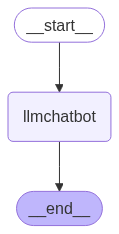

In [10]:
# visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))

except Exception as e:
    pass


In [11]:
graph.invoke("Hi")

InvalidUpdateError: Expected dict, got Hi
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

In [12]:
response = graph.invoke({"messages":"Hi"})

In [13]:
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='a4b758e4-b2d6-4690-975b-4843953e8785'),
 AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.057525924, 'prompt_time': 0.010263137, 'queue_time': 0.7899059319999999, 'total_time': 0.067789061}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e23029c-6e45-4b64-b2cd-6229afbc01ce-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]

In [14]:
response["messages"][-1]

AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.057525924, 'prompt_time': 0.010263137, 'queue_time': 0.7899059319999999, 'total_time': 0.067789061}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e23029c-6e45-4b64-b2cd-6229afbc01ce-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})

In [15]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [16]:
for event in graph.stream({"messages":"Hi"}):
    print(event)

{'llmchatbot': {'messages': [AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.0577668, 'prompt_time': 0.009486007, 'queue_time': 0.329517615, 'total_time': 0.067252807}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--0e683fb8-8001-4532-bf13-f902efa88710-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]}}


In [17]:
for event in graph.stream({"messages":"Hi"}):
    for value in event.values():
        print(value)

{'messages': [AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.03858004, 'prompt_time': 0.004580321, 'queue_time': 0.23614401000000002, 'total_time': 0.043160361}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--1ffc9759-365e-4dc2-a233-123961372865-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]}


In [18]:
for event in graph.stream({"messages":"Hi"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?


CHATBOT WITH TOOL

In [19]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("what is langgraph")

{'query': 'what is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [20]:
##custom function
def multiply(a:int, b:int) -> int:
    """multiplt a and b
    Args:
    a (int): first int
    b (int): second int

    Returns:
    int: output int
    """

In [21]:
tools = [tool, multiply]

In [22]:
llm_with_tool = llm.bind_tools(tools)

In [23]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000194EB423560>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000194EB423CE0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

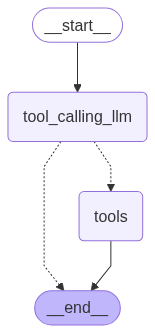

In [28]:
##stateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display


##Node Definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

##Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    #If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    #If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition 
    )
builder.add_edge("tools", END)

#Compile the Graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [29]:
response = graph.invoke({"messages": "what is the recent AI news"})

In [30]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ainvest.com/news/amazon-ai-ambitions-commerce-giant-surpass-nvidia-microsoft-valuation-2030-2507/", "title": "Amazon\'s AI Ambitions: Why the E-commerce Giant Could Surpass Nvidia and Microsoft in Valuation by 2030 - AInvest", "score": 0.6897452, "published_date": "Sun, 13 Jul 2025 01:00:44 GMT", "content": "Amazon\'s AI business has achieved a multi-billion-dollar annual run rate with triple-digit growth rates, positioning Amazon advantageously in the generative AI transformation sweeping through enterprise technology . Recent AWS developments demonstrate the company\'s commitment to AI leadership, including the introduction of Amazon Nova Canvas with AI-powered image generation capabilities and the availability of Anthropic Claude 4 models through Amazon Bedrock . [...] Amazon (AMZN) continues to leverage artificial intelligence (AI) across its business to drive gr

In [32]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (dx7ek9b36)
 Call ID: dx7ek9b36
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ainvest.com/news/amazon-ai-ambitions-commerce-giant-surpass-nvidia-microsoft-valuation-2030-2507/", "title": "Amazon's AI Ambitions: Why the E-commerce Giant Could Surpass Nvidia and Microsoft in Valuation by 2030 - AInvest", "score": 0.6897452, "published_date": "Sun, 13 Jul 2025 01:00:44 GMT", "content": "Amazon's AI business has achieved a multi-billion-dollar annual run rate with triple-digit growth rates, positioning Amazo

In [33]:
response = graph.invoke({"messages": "what is 5 multiplied by 2"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (96pj35s1a)
 Call ID: 96pj35s1a
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

null


In [35]:
response = graph.invoke({"messages": "what is 5 multiplied by 2 and then multiply 10"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 5 multiplied by 2 and then multiply 10
================================== Ai Message ==================================
Tool Calls:
  multiply (5sn3nfs07)
 Call ID: 5sn3nfs07
  Args:
    a: 5
    b: 2
  multiply (9bpg8dm41)
 Call ID: 9bpg8dm41
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: multiply

null
================================= Tool Message =================================
Name: multiply

null


In [36]:
response = graph.invoke({"messages": "give me recent AI news and then multiply 5 by 10"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

give me recent AI news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (z9cg4h11k)
 Call ID: z9cg4h11k
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/elon-musks-grok-4-a-new-player-in-the-ai-intelligence-arena", "title": "Elon Musk's Grok 4: A New Player in the AI Intelligence Arena - OpenTools", "score": 0.7515939, "published_date": "Sat, 12 Jul 2025 01:02:59 GMT", "content": "Published Time: 2025-07-12T01:02:45.505Z\n\nNews Not Found | AI News\n\n===============\n\nOpenToolsImage 1: logo\n\nOpen main menu\n\nNewsletterNewsSubmit A ToolAdvertise\n\nCategorie

In [39]:
# In above, multiplication of 5 * 10 is missing


ReAct Agent Architechture

Act Observe & Reason

Act by calling tool node, and observe the response given by the tools and decide again whether to call toolNodr or not. and then Reason that is provide the output to the user according to the outputs generated b the tools

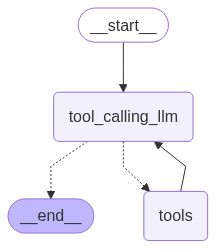

In [37]:
##stateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display


##Node Definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

##Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    #If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    #If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition 
    )
builder.add_edge("tools", "tool_calling_llm")

#Compile the Graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [38]:
response = graph.invoke({"messages": "give me recent AI news and then multiply 5 by 10"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

give me recent AI news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (gnx7ttt3m)
 Call ID: gnx7ttt3m
  Args:
    query: recent AI news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest AI News, Analysis & Events", "content": "AI is rewriting the rules of the insurance industry · IBM Power11 targets enterprise AI adoption with zero-downtime architecture · Google's open MedGemma AI", "score": 0.7892503, "raw_content": null}, {"url": "https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=ASWzDAj3pWuQJhdfWurpw1YtPL4ORD4Y-EOtMRre2dAFEZeKLCxJO3OmPcq-&gaa_ts=6873c64e&gaa_sig=K6xkbKc1vSTs7q9arES23pnb-lN9

Adding Memory to Agentic Graph

In [40]:
response = graph.invoke({"messages": "Hi My name is Jeevan"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi My name is Jeevan
================================== Ai Message ==================================

Nice to meet you, Jeevan! What brings you here today?


In [41]:
response = graph.invoke({"messages": "what is my name?"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================
Tool Calls:
  multiply (sj3cqyz5w)
 Call ID: sj3cqyz5w
  Args:
    a: 0
    b: 0
================================= Tool Message =================================
Name: multiply

null
================================== Ai Message ==================================

I apologize, but I didn't expect the tool to yield null. Since no relevant tool is available, I will respond directly to your question.

You didn't mention your name, so I don't have any information about it. If you'd like to provide your name, I'd be happy to know it.


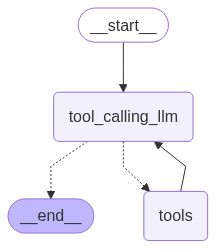

In [46]:
##stateGraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


##Node Definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

##Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    #If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    #If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition 
    )
builder.add_edge("tools", "tool_calling_llm")

#Compile the Graph
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [47]:
config={"configurable": {"thread_id":"1"}}

response = graph.invoke({"messages": "Hi My name is Jeevan"},config=config)

response

{'messages': [HumanMessage(content='Hi My name is Jeevan', additional_kwargs={}, response_metadata={}, id='94815ead-7e8c-44be-acb0-e0d525b2216f'),
  AIMessage(content='Nice to meet you, Jeevan!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 2264, 'total_tokens': 2274, 'completion_time': 0.015585917, 'prompt_time': 0.260994158, 'queue_time': 0.900455679, 'total_time': 0.276580075}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--0a698e60-6a7a-4188-a6d7-6b340329d7ca-0', usage_metadata={'input_tokens': 2264, 'output_tokens': 10, 'total_tokens': 2274})]}

In [48]:
response["messages"][-1].content

'Nice to meet you, Jeevan!'

In [50]:
response = graph.invoke({"messages": "Hey, what is my name?"},config=config)
print(response["messages"][-1].content)


Based on the tool call result, I can see that the answer is not explicitly provided, but I can extract the relevant information from the result. It seems that Jeevan is an Indian sub-continent first name meaning "life" or "bringer of life".


Streaming in Langgraph

we will see different STREAMING techniques to get response from chatbot when we execute a GRAPH

In [51]:
# first initialize a memory saver
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()


In [52]:
#chatbot NODE
def superbot(state: State):
    return {"messages": [llm.invoke(state['messages'])]}

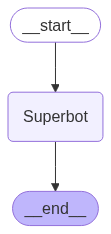

In [54]:
graph=StateGraph(State)

graph.add_node("Superbot", superbot)

graph.add_edge(START, "Superbot")
graph.add_edge("Superbot", END)

graph_builder=graph.compile(checkpointer=memory)

#Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [55]:
## create a THREAD
config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({"messages": "Hi, My name is Jeevan and I like Basketball"}, config)


{'messages': [HumanMessage(content='Hi, My name is Jeevan and I like Basketball', additional_kwargs={}, response_metadata={}, id='04557bb3-4b5d-48c7-be09-64dbd0a96234'),
  AIMessage(content="Nice to meet you, Jeevan! That's awesome that you like basketball! Do you have a favorite team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 22, 'total_tokens': 49, 'completion_time': 0.018840362, 'prompt_time': 0.004014114, 'queue_time': 0.194040672, 'total_time': 0.022854476}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--d0f71e4f-df63-41b7-a228-e559ddc46652-0', usage_metadata={'input_tokens': 22, 'output_tokens': 27, 'total_tokens': 49})]}

Streaming
Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

values : This streams the full state of the graph after each node is called.

updates : This streams updates to the state of the graph after each node is called.

In [57]:
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({"messages": "Hi, My name is Jeevan and I like cricket"}, config, stream_mode="updates"):
    print(chunk)

{'Superbot': {'messages': [AIMessage(content='Hi Jeevan! Nice to meet you! Cricket, you say? Which team do you support? Are you a fan of any particular player or a specific tournament like the IPL or the World Cup?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 22, 'total_tokens': 64, 'completion_time': 0.034599256, 'prompt_time': 0.004448401, 'queue_time': 0.223770139, 'total_time': 0.039047657}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--c6e82199-8658-4e9e-9a3b-453ba19cfbf6-0', usage_metadata={'input_tokens': 22, 'output_tokens': 42, 'total_tokens': 64})]}}


In [58]:
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({"messages": "Hi, My name is Jeevan and I like cricket"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Jeevan and I like cricket', additional_kwargs={}, response_metadata={}, id='88eb6e8a-9bf0-4061-941f-1dd37c55d37e'), AIMessage(content='Hi Jeevan! Nice to meet you! Cricket, you say? Which team do you support? Are you a fan of any particular player or a specific tournament like the IPL or the World Cup?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 22, 'total_tokens': 64, 'completion_time': 0.034599256, 'prompt_time': 0.004448401, 'queue_time': 0.223770139, 'total_time': 0.039047657}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--c6e82199-8658-4e9e-9a3b-453ba19cfbf6-0', usage_metadata={'input_tokens': 22, 'output_tokens': 42, 'total_tokens': 64}), HumanMessage(content='Hi, My name is Jeevan and I like cricket', additional_kwargs={}, response_metadata={}, id='58543d5b-bfaf-4087-8d4d-cc51592b61c2')]}
{'messa

{'messages': [HumanMessage(content='Hi, My name is Jeevan and I like cricket', additional_kwargs={}, response_metadata={}, id='88eb6e8a-9bf0-4061-941f-1dd37c55d37e'), AIMessage(content='Hi Jeevan! Nice to meet you! Cricket, you say? Which team do you support? Are you a fan of any particular player or a specific tournament like the IPL or the World Cup?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 22, 'total_tokens': 64, 'completion_time': 0.034599256, 'prompt_time': 0.004448401, 'queue_time': 0.223770139, 'total_time': 0.039047657}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--c6e82199-8658-4e9e-9a3b-453ba19cfbf6-0', usage_metadata={'input_tokens': 22, 'output_tokens': 42, 'total_tokens': 64}), HumanMessage(content='Hi, My name is Jeevan and I like cricket', additional_kwargs={}, response_metadata={}, id='58543d5b-bfaf-4087-8d4d-cc51592b61c2'), AIMessag

In [60]:
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({"messages": "Hi, My name is Jeevan and I like cricket"}, config, stream_mode="updates"):
    print(chunk)

{'Superbot': {'messages': [AIMessage(content="Hello Jeevan! Nice to meet you! Cricket is an amazing sport, isn't it? Which team do you support? Are you a fan of the Indian national team or maybe a different team like Australia, England, or Pakistan?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 22, 'total_tokens': 71, 'completion_time': 0.040736348, 'prompt_time': 0.004500993, 'queue_time': 0.19377477199999998, 'total_time': 0.045237341}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--0367371c-1226-4af6-954e-28f98879cc19-0', usage_metadata={'input_tokens': 22, 'output_tokens': 49, 'total_tokens': 71})]}}


In [61]:
for chunk in graph_builder.stream({"messages": "I also like basketball"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Jeevan and I like cricket', additional_kwargs={}, response_metadata={}, id='4a8beaf8-dcdf-407d-baeb-01e3cd366258'), AIMessage(content="Hello Jeevan! Nice to meet you! Cricket is an amazing sport, isn't it? Which team do you support? Are you a fan of the Indian national team or maybe a different team like Australia, England, or Pakistan?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 22, 'total_tokens': 71, 'completion_time': 0.040736348, 'prompt_time': 0.004500993, 'queue_time': 0.19377477199999998, 'total_time': 0.045237341}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--0367371c-1226-4af6-954e-28f98879cc19-0', usage_metadata={'input_tokens': 22, 'output_tokens': 49, 'total_tokens': 71}), HumanMessage(content='I also like basketball', additional_kwargs={}, response_metadata={}, id='9bc2810b-8269-4da9-8dc6

ASTREAM

In [63]:
config = {"configurable": {"thread_id": "5"}}

async for chunk in graph_builder.astream_events({"messages": "Hi, My name is Jeevan and I like cricket"}, config, stream_mode="updates"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi, My name is Jeevan and I like cricket'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'b16112d2-a5d5-4ba5-91a8-682058497b3f', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, My name is Jeevan and I like cricket', additional_kwargs={}, response_metadata={}, id='0ee7fc27-1d38-4542-a271-c1c82f9442cd')]}}, 'name': 'Superbot', 'tags': ['graph:step:1'], 'run_id': '019ec323-ef8b-4265-aa14-922d8cd42006', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'Superbot', 'langgraph_triggers': ('branch:to:Superbot',), 'langgraph_path': ('__pregel_pull', 'Superbot'), 'langgraph_checkpoint_ns': 'Superbot:d1eb4742-4598-a583-17c5-27c9a9176309'}, 'parent_ids': ['b16112d2-a5d5-4ba5-91a8-682058497b3f']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, My name is Jeevan and I like cricket', addition

Human in the Loop